## AMG results parsing

## Import packages

In [7]:
%matplotlib widget
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch


# from sklearn.preprocessing import MultiLabelBinarizer
# from scipy.cluster.hierarchy import  fcluster


## Define functions, variables and paths

In [8]:

def custom_agg(series):
    non_nan = series.dropna().unique()
    if len(non_nan) == 0:
        return np.nan
    elif len(non_nan) == 1:
        return non_nan[0]
    else:
        return list(series)

In [ ]:
work_dir="/home/lmf/DANIEL/VIRAL_METAGENOMES/"
mapping_dir="/home/lmf/DANIEL/VIRAL_METAGENOMES/06_MAPPING"


DRAM_file=work_dir + "07_ANNOTATION/vDRAM_distill_results_tot/amg_summary.tsv"
pharokka_file=work_dir + "07_ANNOTATION/vDRAM_results_tot_pharokka/pharokka_cds_final_merged_output.tsv"
clusters_file=work_dir + "07_ANNOTATION/vDRAM_annotate_results_tot/genes_cluster.tsv"


SAMPLES=[]
files=glob.glob(work_dir + "02_CLEAN_DATA/*reverse_paired_clean.tot.fastq.gz")
for f in files:
    SAMPLES.append(os.path.basename(f).split("_reverse")[0])
SAMPLES.sort()
print(SAMPLES)


['B_C1_V', 'B_C2_V', 'B_C3_V', 'B_C4_V', 'B_CIT1B_V', 'B_CIT1F_V', 'B_CIT2B_V', 'B_CIT2F_V', 'B_CIT3B_V', 'B_CIT3F_V', 'B_CIT4B_V', 'B_CIT4F_V', 'B_CNT1B_V', 'B_CNT1F_V', 'B_CNT2B_V', 'B_CNT2F_V', 'B_CNT3B_V', 'B_CNT3F_V', 'B_CNT4B_V', 'B_CNT4F_V', 'B_OIT1B_V', 'B_OIT1F_V', 'B_OIT2B_V', 'B_OIT2F_V', 'B_OIT3B_V', 'B_OIT3F_V', 'B_OIT4B_V', 'B_OIT4F_V', 'B_ORT1B_V', 'B_ORT1F_V', 'B_ORT2B_V', 'B_ORT2F_V', 'B_ORT3B_V', 'B_ORT3F_V', 'B_ORT4B_V', 'B_ORT4F_V', 'RS_C1_V', 'RS_C2_V', 'RS_C3_V', 'RS_C4_V', 'RS_CIT1B_V', 'RS_CIT1F_V', 'RS_CIT2B_V', 'RS_CIT2F_V', 'RS_CIT3B_V', 'RS_CIT3F_V', 'RS_CIT4B_V', 'RS_CIT4F_V', 'RS_CNT1B_V', 'RS_CNT1F_V', 'RS_CNT2B_V', 'RS_CNT2F_V', 'RS_CNT3B_V', 'RS_CNT3F_V', 'RS_CNT4B_V', 'RS_CNT4F_V', 'RS_OIT1B_V', 'RS_OIT1F_V', 'RS_OIT2B_V', 'RS_OIT2F_V', 'RS_OIT3B_V', 'RS_OIT3F_V', 'RS_OIT4B_V', 'RS_OIT4F_V', 'RS_ORT1B_V', 'RS_ORT1F_V', 'RS_ORT2B_V', 'RS_ORT2F_V', 'RS_ORT3B_V', 'RS_ORT3F_V', 'RS_ORT4B_V', 'RS_ORT4F_V']


# Parse gene counts

In [10]:
print("NUMBER OF SAMPLES =" , len(SAMPLES))
REFERENCE="predicted_genes_NR_95_85_150bp"
SAMPLING="tot"
# Initialize a dict to hold one DataFrame per metric
metric_dfs = {
    "Mean": {},
    "CoveredBases": {},
    "ReadCount": {},
    "Variance": {},
    "TrimmedMean": {},
    "RPKM": {},
    "CoveredPercent": {}
}

for n, sample in enumerate(SAMPLES):
    print(round(((n + 1) * 100 / len(SAMPLES)), 1), "%", end="\r")
    
    all_file = f"{mapping_dir}/GENES/bowtie2_{REFERENCE}_{sample}_{SAMPLING}_covstats.txt"
    
    sample_df = pd.read_csv(
        all_file,
        sep="\t",
        names=["Gene", "Mean", "Length", "CoveredBases", "ReadCount", "Variance", "TrimmedMean", "RPKM"],
        skiprows=1,
        index_col=0
    )
    
    sample_df["CoveredPercent"] = sample_df["CoveredBases"] * 100 / sample_df["Length"]
    
    # Store each metric by sample
    for metric in metric_dfs:
        metric_dfs[metric][sample] = sample_df[metric]

# Convert each metric dictionary into a DataFrame
for metric in metric_dfs:
    metric_dfs[metric] = pd.DataFrame(metric_dfs[metric])

# Example: show the RPKM matrix (rows = contigs, columns = samples)
mean_df = metric_dfs["Mean"]
coveredbases_df = metric_dfs["CoveredBases"]
readcount_df = metric_dfs["ReadCount"]
variance_df = metric_dfs["Variance"]
trimmedmean_df = metric_dfs["TrimmedMean"]
rpkm_df = metric_dfs["RPKM"]
coveredpercent_df = metric_dfs["CoveredPercent"]

readcount_df.to_csv(mapping_dir +  "/GENES/abundance_counts_predicted_genes_NR_95_85_150bp.tsv", sep="\t")


NUMBER OF SAMPLES = 72


## Merge annotations

In [ ]:
DRAMv_df=pd.read_csv(DRAM_file, sep="\t")
DRAMv_df = DRAMv_df.add_prefix("DRAM_")
DRAMv_df=DRAMv_df.groupby("DRAM_gene", as_index=False).agg(lambda x: custom_agg(x))

pharokka_df=pd.read_csv(pharokka_file,sep="\t")
pharokka_df["gene_DRAM"] = pharokka_df["gene"].str.replace(r"_CDS_0*", "_", regex=True).str.replace(r"_CDS", "", regex=False)
pharokka_df = pharokka_df.add_prefix("pharokka_")

clusters_df=pd.read_csv(clusters_file, sep="\t", names=["PC_rep", "PC_mem"])

combined_annotations=clusters_df.merge(DRAMv_df, left_on="PC_mem", right_on="DRAM_gene", how="left").merge(pharokka_df, left_on="PC_mem", right_on="pharokka_gene_DRAM", how="left")
combined_annotations["gene_description_sortable"] = combined_annotations["DRAM_gene_description"].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else str(x))
combined_annotations["gene_description_len"] = combined_annotations["gene_description_sortable"].str.len()
combined_annotations=combined_annotations.sort_values("gene_description_len", ascending=False).groupby("PC_mem").first()

combined_annotations.to_csv(work_dir + "07_ANNOTATION/gene_annotation_table.tsv", sep="\t")
combined_annotations

## Visualization

,pharokka_gene,pharokka_start,pharokka_stop,pharokka_frame,pharokka_contig,pharokka_score,pharokka_mmseqs_phrog,pharokka_mmseqs_alnScore,pharokka_mmseqs_seqIdentity,pharokka_mmseqs_eVal,...,pharokka_ARO_Accession,pharokka_CARD_short_name,pharokka_Protein_Accession,pharokka_DNA_Accession,pharokka_AMR_Gene_Family,pharokka_Drug_Class,pharokka_Resistance_Mechanism,pharokka_transl_table,pharokka_gene_DRAM,len
58777,B_CIT3F_V_90_NODE_292_length_14890_cov_6.90569...,14829,14888,+,B_CIT3F_V_90_NODE_292_length_14890_cov_6.90569...,No_score,No_PHROG,No_PHROG,No_PHROG,No_PHROG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,B_CIT3F_V_90_NODE_292_length_14890_cov_6.90569...,59
28958,B_ORT2B_V_NODE_29_length_11088_cov_8.999366-ca...,62,3,-,B_ORT2B_V_NODE_29_length_11088_cov_8.999366-cat_1,No_score,No_PHROG,No_PHROG,No_PHROG,No_PHROG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,B_ORT2B_V_NODE_29_length_11088_cov_8.999366-ca...,59
38954,RS_OIT4B_V_NODE_5_length_15593_cov_7.238512-ca...,15534,15593,+,RS_OIT4B_V_NODE_5_length_15593_cov_7.238512-cat_1,No_score,No_PHROG,No_PHROG,No_PHROG,No_PHROG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,RS_OIT4B_V_NODE_5_length_15593_cov_7.238512-ca...,59
58983,B_CIT3F_V_90_NODE_369_length_12384_cov_7.86689...,12323,12382,+,B_CIT3F_V_90_NODE_369_length_12384_cov_7.86689...,No_score,No_PHROG,No_PHROG,No_PHROG,No_PHROG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,B_CIT3F_V_90_NODE_369_length_12384_cov_7.86689...,59
60962,B_CIT4F_V_90_NODE_63_length_14666_cov_12.37731...,61,2,-,B_CIT4F_V_90_NODE_63_length_14666_cov_12.37731...,No_score,No_PHROG,No_PHROG,No_PHROG,No_PHROG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,B_CIT4F_V_90_NODE_63_length_14666_cov_12.37731...,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,B_C4_V_NODE_1_length_65611_cov_14.826576-cat_1...,34214,21567,-,B_C4_V_NODE_1_length_65611_cov_14.826576-cat_1,No_score,9854,202.0,0.208,1.951e-51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,B_C4_V_NODE_1_length_65611_cov_14.826576-cat_1_46,12647
73473,B_OIT2B_V_90_NODE_6_length_43491_cov_9.065683-...,2874,16040,+,B_OIT2B_V_90_NODE_6_length_43491_cov_9.065683-...,No_score,2013,102.0,0.519,1.146e-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,B_OIT2B_V_90_NODE_6_length_43491_cov_9.065683-...,13166
25333,B_OIT1B_V_NODE_11_length_32517_cov_9.718532-ca...,25481,10599,-,B_OIT1B_V_NODE_11_length_32517_cov_9.718532-cat_1,No_score,No_PHROG,No_PHROG,No_PHROG,No_PHROG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,B_OIT1B_V_NODE_11_length_32517_cov_9.718532-ca...,14882
22512,B_CNT4F_V_NODE_12_length_55222_cov_9.017800-ca...,26012,41656,+,B_CNT4F_V_NODE_12_length_55222_cov_9.017800-cat_2,No_score,22413,164.0,0.44,2.11e-45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom_gene_calls_from_genbank,B_CNT4F_V_NODE_12_length_55222_cov_9.017800-ca...,15644


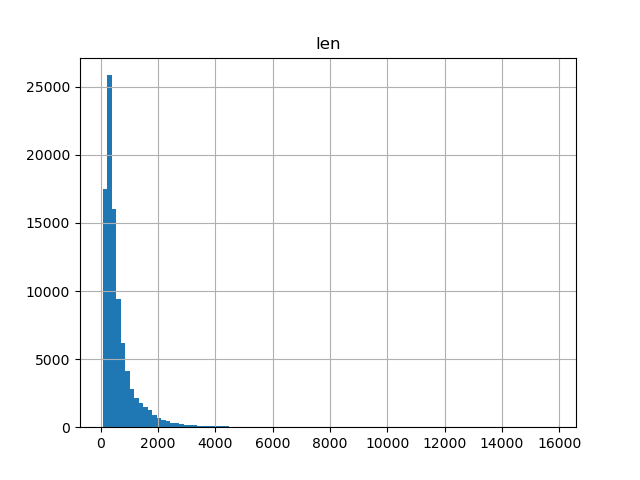

In [19]:
pharokka_df["len"]=abs(pharokka_df["pharokka_start"]-pharokka_df["pharokka_stop"])
pharokka_df[["len"]].hist(bins=100)
pharokka_df.sort_values("len")

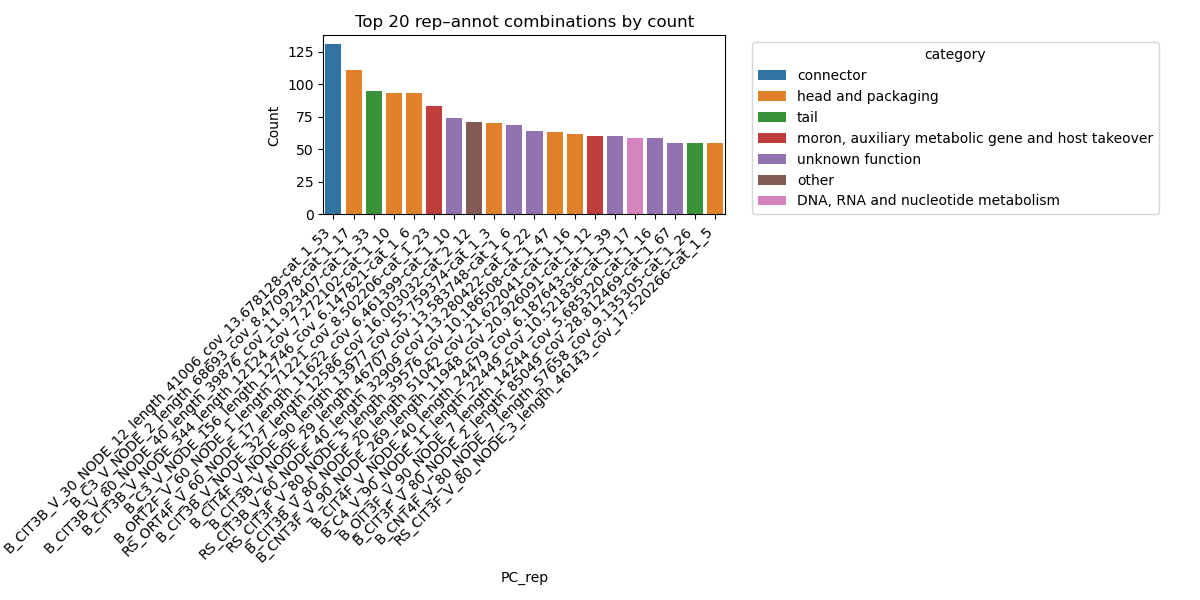

In [20]:
grouped=combined_annotations.groupby(["PC_rep", "pharokka_category"]).size().reset_index(name="count").sort_values("count", ascending=False)[:20]
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x="PC_rep", y="count", hue="pharokka_category")

# Styling
plt.title("Top 20 rep–annot combinations by count")
plt.xlabel("PC_rep")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
